In [1]:
import pandas
import math
import json
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

In [2]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



In [3]:
contents = pandas.read_csv('out.csv')

In [4]:
import matplotlib.pyplot as plt

In [5]:
def add_to_dict(dic, val):
    if val not in dic.keys():
        dic[val] = 1
    else:
        dic[val] += 1

In [6]:
all_ages = {}
all_gender = {}
all_educations = {}

for row in contents.iterrows():
    row_data = row[1]['datastring']
    if isinstance(row_data,str):
        json_data = json.loads(row_data)
        add_to_dict(all_ages, json_data['questiondata']['age'])
        add_to_dict(all_gender,json_data['questiondata']['gender'])
        add_to_dict(all_educations,json_data['questiondata']['education'])

In [7]:
all_ages

{'31-35': 13, '41-45': 14, '36-40': 14, '45-50': 20, '26-30': 4}

In [8]:
all_ages_ = {}
all_ages_['35-45'] = all_ages['36-40'] + all_ages['41-45']
all_ages_['<35'] = all_ages['26-30'] + all_ages['31-35']
all_ages_['>45'] = all_ages['45-50']

In [9]:
all_ages_

{'35-45': 28, '<35': 17, '>45': 20}

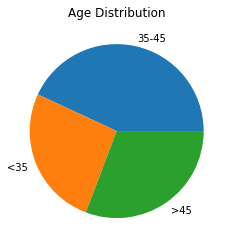

In [10]:
plt.pie(all_ages_.values(), labels = all_ages_.keys())
plt.title('Age Distribution')
plt.show() 

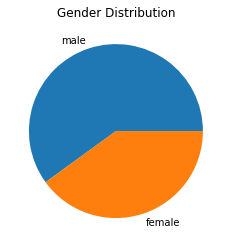

In [11]:
plt.pie(all_gender.values(), labels = all_gender.keys())
plt.title('Gender Distribution')
plt.show() 

In [12]:
all_gender

{'male': 39, 'female': 26}

In [13]:
all_educations_ = {}
all_educations_['Below Bachelors'] = all_educations['high school'] + all_educations['middle school']
all_educations_['Bachelors'] = all_educations['bachelor']
all_educations_['Above Bachelors'] = all_educations['master']

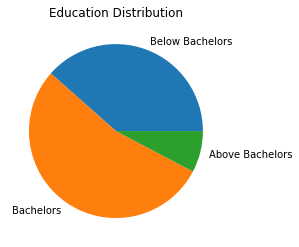

In [14]:
plt.pie(all_educations_.values(), labels = all_educations_.keys())
plt.title('Education Distribution')
plt.show() 

In [15]:
all_educations_

{'Below Bachelors': 25, 'Bachelors': 35, 'Above Bachelors': 5}

In [16]:
page_to_class = {}
page_to_class['a'] = 'H'
page_to_class['b'] = 'AI'
page_to_class['c'] = 'AI'
page_to_class['d'] = 'AI'


page_to_algo = {}
page_to_algo['a'] = 'humans'
page_to_algo['b'] = 'azure'
page_to_algo['c'] = 'mccq'
page_to_algo['d'] = 'google'

In [17]:
all_gender

{'male': 39, 'female': 26}

In [18]:
all_educations.keys()

dict_keys(['bachelor', 'master', 'high school', 'middle school'])

In [19]:
def parse_all_data(contents,allowed_algos = ['humans', 'azure', 'detectron', 'google', 'rekognition'], allowed_ages = all_ages.keys(), allowed_genders = all_gender.keys(), allowed_educations = all_educations.keys()):
    person_to_personal_df = {}   
    for row in contents.iterrows():
        row_data = row[1]['datastring']
        if isinstance(row_data,str):
            json_data = json.loads(row_data)
            person_id = json_data['workerId']
            person_questionnaire = json_data['questiondata']
            person_age = person_questionnaire['age']
            person_gender = person_questionnaire['gender']
            person_education = person_questionnaire['education']
            person_df = pandas.DataFrame(columns = ['image','topic_match','response_class','actual_class','class_match','response_gender'])
            for i in range(1,26):
                ques_output = {}
                ques_response = json_data['data'][i]['trialdata']
                image = ques_response['imageID']
                topic_match = int(ques_response['topic']) == int(ques_response['oneWord_curr']) + 1
                
                response_class = ques_response['Aclass']
                actual_class = page_to_class[ques_response['page_name'].split('_')[1]]
                class_match = response_class == actual_class

                response_gender = ques_response['Agender']
                algo = page_to_algo[ques_response['page_name'].split('_')[1]]
                page_name = ques_response['page_name']
                if algo in allowed_algos and person_age in allowed_ages and person_gender in allowed_genders and person_education in allowed_educations:
                    person_df = person_df.append({'image' : image, 'topic_match' : topic_match, 'response_class' : response_class,'actual_class':actual_class, 'class_match':class_match, 'response_gender': response_gender, 'page_name': page_name},ignore_index = True)
            if len(person_df) > 0:
                person_to_personal_df[person_id] = person_df
    return person_to_personal_df

In [20]:
def run_analysis(person_to_personal_df, verbose = False):
    prediction_accs = []
    topic_accs = []
    all_images = []
    all_actuals = []
    all_response_classes = []
    all_genders = []

    result_mean = []
    result_std = [] #std for individual categories: e.g. humans alone, AI alone, each model alone
    top_std = [] 

    for person_id in person_to_personal_df.keys():
        person_df = person_to_personal_df[person_id]
        all_images.extend(list(person_df['image']))
        all_actuals.extend(list(person_df['actual_class']))
        all_response_classes.extend(list(person_df['response_class']))
        all_genders.extend(list(person_df['response_gender']))

        topic_accuracy = np.sum(person_df['topic_match'])/len(person_df['topic_match'])
        prediction_accuracy = np.sum(person_df['class_match'])/len(person_df['class_match'])
        topic_accs.append(topic_accuracy)
        prediction_accs.append(prediction_accuracy)
    
    if verbose:
        print('Mean Topic Prediction:%s'%np.mean(topic_accs))
        print('Mean AI/H Prediction:%s'%np.mean(prediction_accs))
        print('Female prediction rate:%s'%(all_genders.count('F')/len(all_genders)))
    
    h_h = 0
    h_ai = 0
    ai_h = 0
    ai_ai = 0
    
    result = {'human':0, 'countH':0, 'list_human':[], 'machine':0, 'countM': 0, 'list_machine':[]} #machine is overall AI; countM is the total num of AI ground truth
    
    all_actuals_gts = [all_actuals, all_response_classes,all_images]
    for i in range(len(all_actuals)):
        if all_actuals[i] == 'H':
            result['countH'] += 1
            if all_response_classes[i] == 'H':
                h_h += 1
                result['human'] += 1
                result['list_human'].append(1)
            if all_response_classes[i] == 'AI':
                h_ai += 1
                result['list_human'].append(0)
        if all_actuals[i] == 'AI':
            result['countM'] += 1
            if all_response_classes[i] == 'H':
                ai_h += 1
                result['list_machine'].append(0)
            if all_response_classes[i] == 'AI':
                ai_ai += 1
                result['machine'] += 1
                result['list_machine'].append(1)
    
    confusion_df = pandas.DataFrame([[h_h/(h_h+h_ai), h_ai/(h_h+h_ai)], [ai_h/(ai_h+ai_ai), ai_ai/(ai_h+ai_ai)]], columns=['H','AI'], index=['H', 'AI'])
    if verbose:
        print(confusion_df)
    result_mean.append(sum(result['list_human'])/len(result['list_human']))
    result_std.append(np.std(np.array(result['list_human']), axis=0))
    result_mean.append(sum(result['list_human'])/len(result['list_human']))
    result_std.append(np.std(np.array(result['list_human']), axis=0))
    top_std.append(boostrap(result['list_human'], result['list_machine']))
    return np.mean(prediction_accs),confusion_df, all_actuals_gts, top_std 

In [21]:
def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)
        
    #print(BootstrapTimes)        
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))
    
    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

# Humans vs All

In [22]:
all_educations

{'bachelor': 35, 'master': 5, 'high school': 24, 'middle school': 1}

In [23]:
means = {}
dfs = {}
results = {}
stds = {}

In [24]:
means['all'] = {}
means['azure'] = {}
means['mccq'] = {}
means['google'] = {}

dfs['all'] = {}
dfs['azure'] = {}
dfs['mccq'] = {}
dfs['google'] = {}

results['all'] = {}
results['azure'] = {}
results['mccq'] = {}
results['google'] = {}

stds['all'] = {}
stds['azure'] = {}
stds['mccq'] = {}
stds['google'] = {}

In [25]:
# print('starting overall...')
# parsed_data = parse_all_data(contents)
# # means['all']['all'], dfs['all']['all'] = run_analysis(parsed_data)

In [26]:
# for key in parsed_data.keys():
#     c = parsed_data[key]
#     break

In [27]:
# c

In [28]:
# from PIL import Image

In [29]:
# for row in c.iterrows():
#     plt.imshow(Image.open(row[1].image))
#     plt.axis('off')
#     plt.show()
#     with open('static/responses_color/%s'%row[1].page_name.replace('html/','html'),'r') as F:
#         contents = F.readlines()
#     print('Response: %s'%contents[0].split('Response: ')[1].split('<')[0])
#     print('Actual Speaker: %s'%row[1].actual_class.replace('H','Human').replace('AI','Machine'))
#     print('Human Judge Prediction: %s'%row[1].response_class.replace('H','Human').replace('AI','Machine'))

In [30]:
print('starting overall...')
parsed_data = parse_all_data(contents)
means['all']['all'], dfs['all']['all'],results['all']['all'],stds['all']['all'] = run_analysis(parsed_data)

starting overall...


In [31]:
# Age
print('starting age...')
parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'])
means['all']['all_35'], dfs['all']['all_35'],results['all']['all_35'],stds['all']['all_35'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'])
means['all']['all_35_45'], dfs['all']['all_35_45'],results['all']['all_35_45'],stds['all']['all_35_45'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_ages=['45-50'])
means['all']['all_45'], dfs['all']['all_45'],results['all']['all_45'],stds['all']['all_45'] = run_analysis(parsed_data)

# Education
print('starting education...')
parsed_data = parse_all_data(contents,allowed_educations=['high school'])
means['all']['all_edu_1'], dfs['all']['all_edu_1'],results['all']['all_edu_1'],stds['all']['all_edu_1'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_educations=['bachelor'])
means['all']['all_edu_2'], dfs['all']['all_edu_2'],results['all']['all_edu_2'],stds['all']['all_edu_2'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_educations=['master','pg'])
means['all']['all_edu_3'], dfs['all']['all_edu_3'],results['all']['all_edu_3'],stds['all']['all_edu_3'] = run_analysis(parsed_data)

# Gender
print('starting gender...')
parsed_data = parse_all_data(contents,allowed_genders=['male'])
means['all']['all_male'], dfs['all']['all_male'],results['all']['all_male'],stds['all']['all_male'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_genders=['female'])
means['all']['all_female'], dfs['all']['all_female'],results['all']['all_female'],stds['all']['all_female'] = run_analysis(parsed_data)

starting age...
starting education...
starting gender...


In [32]:
# # Age
# print('starting age...')
# parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'])
# means['all']['all_35'], dfs['all']['all_35'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'])
# means['all']['all_35_45'], dfs['all']['all_35_45'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['45-50'])
# means['all']['all_45'], dfs['all']['all_45'] = run_analysis(parsed_data)

# # Education
# print('starting education...')
# parsed_data = parse_all_data(contents,allowed_educations=['middle school', 'high school'])
# means['all']['all_edu_1'], dfs['all']['all_edu_1'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['bachelor'])
# means['all']['all_edu_2'], dfs['all']['all_edu_2'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['master'])
# means['all']['all_edu_3'], dfs['all']['all_edu_3'] = run_analysis(parsed_data)

# # Gender
# print('starting gender...')
# parsed_data = parse_all_data(contents,allowed_genders=['male'])
# means['all']['all_male'], dfs['all']['all_male'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_genders=['female'])
# means['all']['all_female'], dfs['all']['all_female'] = run_analysis(parsed_data)

# Humans vs Azure

In [33]:
for ALGO in ['azure','mccq','google']:
    print(ALGO)
    print('starting overall...')
    parsed_data = parse_all_data(contents, allowed_algos=['humans',ALGO])
    means[ALGO]['all'], dfs[ALGO]['all'], results[ALGO]['all'], stds[ALGO]['all'] = run_analysis(parsed_data)

    # Age
    print('starting age...')
    parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_35'], dfs[ALGO]['all_35'], results[ALGO]['all_35'], stds[ALGO]['all_35'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_35_45'], dfs[ALGO]['all_35_45'], results[ALGO]['all_35_45'], stds[ALGO]['all_35_45'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_ages=['45-50'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_45'], dfs[ALGO]['all_45'], results[ALGO]['all_45'], stds[ALGO]['all_45'] = run_analysis(parsed_data)

    # Education
    print('starting education...')
    parsed_data = parse_all_data(contents,allowed_educations=['high school'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_edu_1'], dfs[ALGO]['all_edu_1'], results[ALGO]['all_edu_1'], stds[ALGO]['all_edu_1'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_educations=['bachelor'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_edu_2'], dfs[ALGO]['all_edu_2'], results[ALGO]['all_edu_2'], stds[ALGO]['all_edu_2'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_educations=['master','pg'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_edu_3'], dfs[ALGO]['all_edu_3'], results[ALGO]['all_edu_3'], stds[ALGO]['all_edu_3'] = run_analysis(parsed_data)

    # Gender
    print('starting gender...')
    parsed_data = parse_all_data(contents,allowed_genders=['male'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_male'], dfs[ALGO]['all_male'], results[ALGO]['all_male'], stds[ALGO]['all_male'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_genders=['female'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_female'], dfs[ALGO]['all_female'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)


    # parsed_data = parse_all_data(contents,['humans','azure'])
    # means['azure'], dfs['azure'] = run_analysis(parsed_data)

azure
starting overall...
starting age...
starting education...
starting gender...
mccq
starting overall...
starting age...
starting education...
starting gender...
google
starting overall...
starting age...
starting education...
starting gender...


In [35]:
# import pickle
# all_H_accuracies = {}
# for key_1 in results.keys():
#     all_H_accuracies[key_1] = {}
#     for key_2 in results[key_1].keys():
#         image_H_accuracy = {}
#         all_actuals_H,all_responses_H,all_images_H = results[key_1][key_2]
#         all_H_accuracy = (np.array(all_actuals_H) == np.array(all_responses_H)).astype('int')
#         for im_ct in range(len(all_images_H)):
#             im = all_images_H[im_ct]
#             image_H_accuracy[im] = all_actuals_H[im_ct] == all_responses_H[im_ct]
#         all_H_accuracies[key_1][key_2] = image_H_accuracy

In [36]:
import pickle
all_H_accuracies = {}
for key_1 in results.keys():
    all_H_accuracies[key_1] = {}
    for key_2 in results[key_1].keys():
        image_H_accuracy = {}
        all_actuals_H,all_responses_H,all_images_H = results[key_1][key_2]
        all_H_accuracy = (np.array(all_actuals_H) == np.array(all_responses_H)).astype('int')
        for im_ct in range(len(all_images_H)):
            im = all_images_H[im_ct]
            if im not in image_H_accuracy.keys(): 
                image_H_accuracy[im] = [all_actuals_H[im_ct] == all_responses_H[im_ct]]
            else:
                image_H_accuracy[im].append(all_actuals_H[im_ct] == all_responses_H[im_ct])
        all_H_accuracies[key_1][key_2] = image_H_accuracy

In [38]:
with open('all_human_data.p','wb') as F:
    all_data = [means, dfs, results, stds, all_H_accuracies]
    pickle.dump(all_data, F)

In [46]:
# ALGO = 'azure'
# print('starting overall...')
# parsed_data = parse_all_data(contents, allowed_algos=['humans',ALGO])
# means[ALGO]['all'], dfs[ALGO]['all'] = run_analysis(parsed_data)

# # Age
# print('starting age...')
# parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35'], dfs[ALGO]['all_35'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35_45'], dfs[ALGO]['all_35_45'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['45-50'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_45'], dfs[ALGO]['all_45'] = run_analysis(parsed_data)

# # Education
# print('starting education...')
# parsed_data = parse_all_data(contents,allowed_educations=['middle school', 'high school'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_1'], dfs[ALGO]['all_edu_1'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['bachelor'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_2'], dfs[ALGO]['all_edu_2'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['master'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_3'], dfs[ALGO]['all_edu_3'] = run_analysis(parsed_data)

# # Gender
# print('starting gender...')
# parsed_data = parse_all_data(contents,allowed_genders=['male'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_male'], dfs[ALGO]['all_male'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_genders=['female'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_female'], dfs[ALGO]['all_female'] = run_analysis(parsed_data)


# # parsed_data = parse_all_data(contents,['humans','azure'])
# # means['azure'], dfs['azure'] = run_analysis(parsed_data)

starting overall...
starting age...
starting education...
starting gender...


# Humans vs mccq

In [61]:
# ALGO = 'mccq'
# print('starting overall...')
# parsed_data = parse_all_data(contents, allowed_algos=['humans',ALGO])
# means[ALGO]['all'], dfs[ALGO]['all'] = run_analysis(parsed_data)

# # Age
# print('starting age...')
# parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35'], dfs[ALGO]['all_35'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35_45'], dfs[ALGO]['all_35_45'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['45-50'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_45'], dfs[ALGO]['all_45'] = run_analysis(parsed_data)

# # Education
# print('starting education...')
# parsed_data = parse_all_data(contents,allowed_educations=['middle school', 'high school'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_1'], dfs[ALGO]['all_edu_1'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['bachelor'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_2'], dfs[ALGO]['all_edu_2'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['master'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_3'], dfs[ALGO]['all_edu_3'] = run_analysis(parsed_data)

# # Gender
# print('starting gender...')
# parsed_data = parse_all_data(contents,allowed_genders=['male'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_male'], dfs[ALGO]['all_male'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_genders=['female'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_female'], dfs[ALGO]['all_female'] = run_analysis(parsed_data)

# # parsed_data = parse_all_data(contents,['humans','detectron'])
# # means['detectron'], dfs['detectron'] = run_analysis(parsed_data)

# Humans vs Google

In [62]:
# ALGO = 'google'
# print('starting overall...')
# parsed_data = parse_all_data(contents, allowed_algos=['humans',ALGO])
# means[ALGO]['all'], dfs[ALGO]['all'] = run_analysis(parsed_data)

# # Age
# print('starting age...')
# parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35'], dfs[ALGO]['all_35'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35_45'], dfs[ALGO]['all_35_45'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['45-50'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_45'], dfs[ALGO]['all_45'] = run_analysis(parsed_data)

# # Education
# print('starting education...')
# parsed_data = parse_all_data(contents,allowed_educations=['middle school', 'high school'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_1'], dfs[ALGO]['all_edu_1'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['bachelor'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_2'], dfs[ALGO]['all_edu_2'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['master'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_3'], dfs[ALGO]['all_edu_3'] = run_analysis(parsed_data)

# # Gender
# print('starting gender...')
# parsed_data = parse_all_data(contents,allowed_genders=['male'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_male'], dfs[ALGO]['all_male'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_genders=['female'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_female'], dfs[ALGO]['all_female'] = run_analysis(parsed_data)
# # parsed_data = parse_all_data(contents,['humans','google'])
# # means['google'], dfs['google'] = run_analysis(parsed_data)

# Plotting

In [68]:
result_conf_mats = {}

In [69]:
for split in ['all','all_35','all_35_45','all_45','all_edu_1','all_edu_2','all_edu_3','all_male','all_female']:
    result_conf_mat = np.zeros((5,2))
    result_conf_mat[0] = np.array(dfs['all'][split])[0]
    result_conf_mat[1] = np.array(dfs['all'][split])[1]
    result_conf_mat[2] = np.array(dfs['azure'][split])[1]
    result_conf_mat[3] = np.array(dfs['mccq'][split])[1]
    result_conf_mat[4] = np.array(dfs['google'][split])[1]
    result_conf_mats[split] = result_conf_mat

In [70]:
def plot_confmat(result_conf_mat, plotname):
    modelist = ['Azure','MCCQ','Google']
    df_cm = pd.DataFrame(result_conf_mat, index = [i for i in ['Human','AI']+modelist],
                  columns = [i for i in ['Human','AI']])
    plt.figure(figsize = (1.2,3.5))
    sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    
    plt.savefig('figures/' + plotname + '_confmat.pdf', bbox_inches='tight')
    plt.show()

In [71]:
# for split in result_conf_mats.keys():
#     result_conf_mat = result_conf_mats[split]
#     plotname = 'dominant_color_recognition_%s'%split
#     plot_confmat(result_conf_mat,plotname)

In [86]:
#compute top 1 accuracy for each AI model and also overall AI
def plot_graph(result_conf_mat, all_stds, plotname):
    modelist = ['Azure','MCCQ','Google']
    top1 = []
#     print(result_conf_mat)
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
#     print(top1)

    import matplotlib.pyplot as plt
    import numpy as np

    #data
    #x-axis
    years = list(range(1, 2+len(modelist)))
    strtask = ['AI'] + modelist
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots()
    
    from matplotlib.patches import Rectangle
    ax.add_patch(Rectangle((-0.5, 0.45), len(top1), 0.1,facecolor='yellow'))

    #bar chart properties
    ax.bar(strtask, top1, yerr=all_stds,
       align='center', alpha=0.5, ecolor='black', capsize=10,
       color ='black', width = 0.3)

    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.3, 1)
    #plt.xlim(0.5, len(years)+0.5)

#     #draw chance 0.5 
#     chancex =np.arange(len(years))
#     plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(2.5)
    fig.set_figheight(5)

    fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()
    fig.savefig('figures/' + plotname + '.pdf', bbox_inches='tight')

In [87]:
converted_stds = {}
for key_1 in ['all', 'all_35', 'all_35_45', 'all_45', 'all_edu_1', 'all_edu_2', 'all_edu_3', 'all_male', 'all_female']:
    converted_stds[key_1] = {}
    for key_2 in ['all', 'azure', 'mccq', 'google']:
        converted_stds[key_1][key_2] = stds[key_2][key_1][0]

In [88]:
# all_stds[0]

No handles with labels found to put in legend.


dominant_color_recognition_all


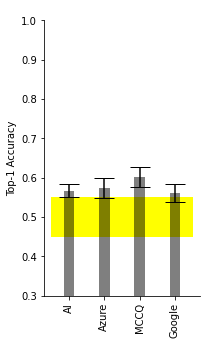

No handles with labels found to put in legend.


dominant_color_recognition_all_35


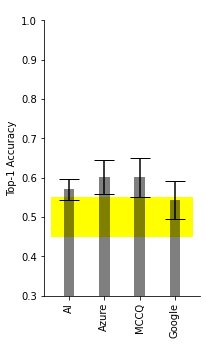

No handles with labels found to put in legend.


dominant_color_recognition_all_35_45


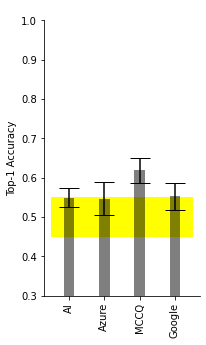

No handles with labels found to put in legend.


dominant_color_recognition_all_45


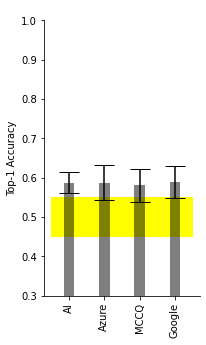

No handles with labels found to put in legend.


dominant_color_recognition_all_edu_1


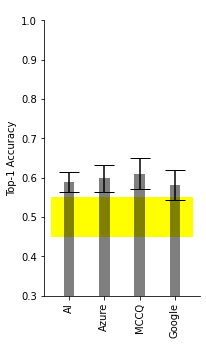

No handles with labels found to put in legend.


dominant_color_recognition_all_edu_2


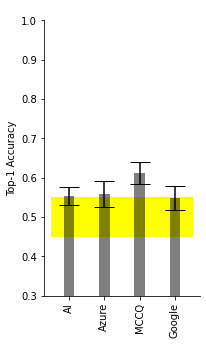

No handles with labels found to put in legend.


dominant_color_recognition_all_edu_3


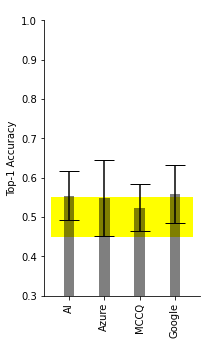

No handles with labels found to put in legend.


dominant_color_recognition_all_male


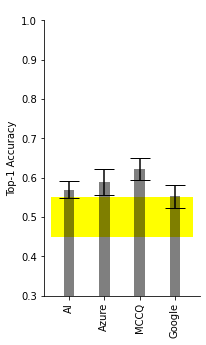

No handles with labels found to put in legend.


dominant_color_recognition_all_female


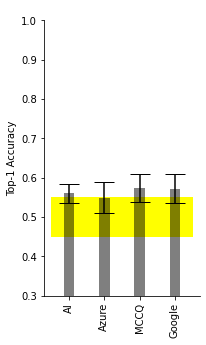

In [89]:
for split in result_conf_mats.keys():
    result_conf_mat = result_conf_mats[split]
    plotname = 'dominant_color_recognition_%s'%split
    all_stds = []
    for key_2 in ['all', 'azure', 'mccq', 'google']:
        all_stds.append(converted_stds[split][key_2])
    print(plotname)
    plot_graph(result_conf_mat,all_stds,plotname)